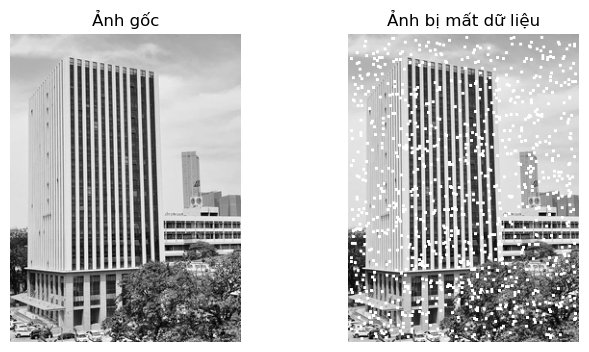

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 1️⃣ Đọc ảnh gốc (ảnh xám)
img = cv2.imread('anhutc.jpg', cv2.IMREAD_GRAYSCALE) 
img = img.astype(np.float32) 
# 2️⃣ Làm mất dữ liệu ngẫu nhiên cùng vùng nhỏ xung quanh
img_missing = img.copy()
h, w = img.shape
num_points = 1000  # Số điểm ngẫu nhiên cần làm mất
patch_size = 3 # Kích thước vùng bị mất xung quanh mỗi điểm

for _ in range(num_points):
    x = np.random.randint(patch_size, w - patch_size)  # Chọn điểm ngẫu nhiên
    y = np.random.randint(patch_size, h - patch_size)
    
    # Làm mất dữ liệu bằng cách đặt pixel về màu trắng (255)
    img_missing[y - patch_size // 2 : y + patch_size // 2 + 1, 
                x - patch_size // 2 : x + patch_size // 2 + 1] = 255

# 3️⃣ Lưu ảnh bị mất dữ liệu
cv2.imwrite("anhutc_missing.png", img_missing)

# 4️⃣ Hiển thị ảnh gốc và ảnh bị mất dữ liệu
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(img, cmap="gray")
axes[0].set_title("Ảnh gốc")
axes[0].axis("off")

axes[1].imshow(img_missing, cmap="gray")
axes[1].set_title("Ảnh bị mất dữ liệu")
axes[1].axis("off")

plt.show()

Kích thước ảnh : 320x240
% ảnh bị mất 11.07%
k0 ban đầu: 2.0
Vòng lặp tối đa (2000) với err = 0.002183
rmse : 0.001463


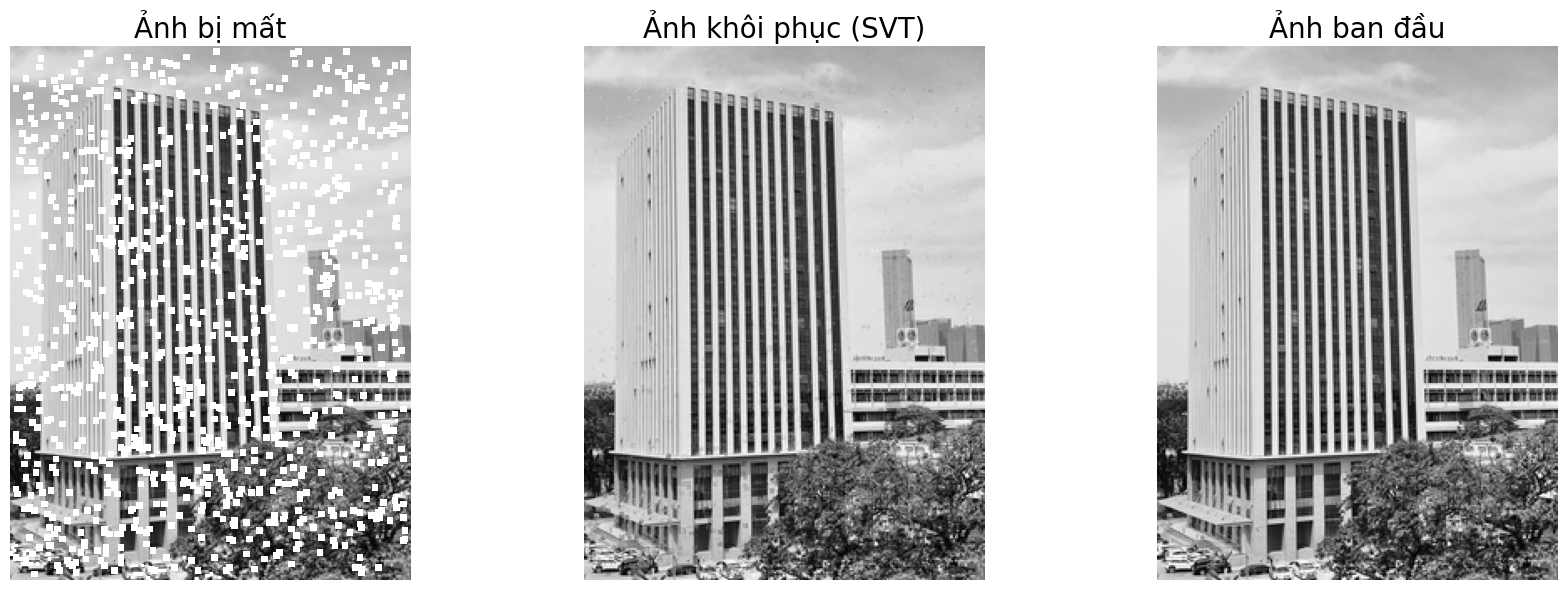

In [291]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.linalg import svd

# 1️⃣ Hàm đọc ảnh dưới dạng ảnh xám (grayscale) và chuẩn hóa về [0, 1]
def load_image(filename):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Không thể tải file: {filename}")
    return img.astype(np.float32) / 255 

# Đọc ảnh gốc và ảnh đã bị làm mất dữ liệu
img = load_image('anhutc.jpg')  # Ảnh gốc
img_missing = load_image('anhutc_missing.png')  # Ảnh có vùng bị mất

print(f'Kích thước ảnh : {img.shape[0]}x{img.shape[1]}',)
# 2️⃣ Tạo mặt nạ cho vùng bị mất dữ liệu

# Giả sử pixel >= 0.99 là vùng bị "trắng xoá" → coi là bị mất
img_missing[img_missing >= 0.99 ] = np.nan  # Gán các pixel bị mất thành NaN

# Tạo mặt nạ: False nếu pixel bị mất (NaN), True nếu còn dữ liệu
mask = ~np.isnan(img_missing)
print(f'% ảnh bị mất {round(np.sum(~mask)*100/ mask.size,2)}%')
# 3️⃣ Thuật toán SVT để khôi phục dữ liệu bị thiếu
def frob_norm(A):
    return np.linalg.norm(A, ord="fro")

def svt_solver(M, mask, tol=1e-4, delta=None, tau=None, n_iters=2000):
    
    # Kiểm tra nếu không có vùng quan sát
    if np.sum(mask) == 0:
        return "Mask không chứa vị trí quan sát nào (toàn bộ là NaN)"

    M_filled = np.copy(M)
    M_filled[np.isnan(M_filled)] = 0

    if not delta:
        delta = 1.2 * np.prod(M.shape) / np.sum(mask)

    if not tau:
        tau = np.sqrt(np.prod(M.shape))  # sqrt(m*n)

    # Tính k0
    norm_M = np.linalg.norm(M_filled, ord=2)
    k0 = np.ceil(tau / (delta * norm_M)) if norm_M > 0 else 1
    
    # Khởi tạo
    X = np.zeros_like(M_filled)
    Y = k0 * delta * mask * M_filled  # Dùng M_filled để khởi tạo Y
    print(f"k0 ban đầu: {k0}")

    for i in range(n_iters):
        # Dùng np.linalg.svd
        u, s, vh = np.linalg.svd(Y, full_matrices=False)
        # Áp dụng ngưỡng tau lên các giá trị đơn
        shrink_s = np.maximum(s - tau, 0)
        r = np.count_nonzero(shrink_s)
        X = u @ np.diag(shrink_s) @ vh
        Y += delta * mask * (M_filled - X)  # Dùng M_filled trong cập nhật
        # Tiêu chí dừng: chỉ tính sai số trên các vị trí quan sát
        # Dùng M_filled thay vì M để tránh NaN
        err = frob_norm(mask * (X - M_filled)) / frob_norm(mask * M_filled)
        if err <= tol:
            print(f"Hội tụ lại vòng lặp {i+1} với err = {round(err,6)}")
            break
    else:
        print(f"Vòng lặp tối đa ({n_iters}) với err = {round(err,6)}")
    return X
# 4️⃣ Thực hiện khôi phục ảnh
img_recovered = svt_solver(img_missing,mask)

# 5️⃣ Tính toán sai số MSE (chỉ tính trên vùng bị mất)
rmse=np.sqrt(np.mean((img_missing[mask]-img_recovered[mask])**2))
print('rmse :', round(rmse,6))

# 6️⃣ Hiển thị ảnh: gồm 3 ảnh (ảnh bị mất, ảnh khôi phục, ảnh gốc)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Ảnh bị mất dữ liệu (ẩn vùng NaN khỏi hiển thị)
axes[0].imshow(np.ma.masked_array(img_missing), cmap='gray', vmin=0, vmax=1)
axes[0].set_title("Ảnh bị mất",fontsize=20)

# Ảnh sau khi khôi phục bằng SVT
axes[1].imshow(img_recovered, cmap='gray', vmin=0, vmax=1)
axes[1].set_title("Ảnh khôi phục (SVT)",fontsize=20)

# Ảnh gốc ban đầu
axes[2].imshow(img, cmap='gray', vmin=0, vmax=1)
axes[2].set_title("Ảnh ban đầu",fontsize=20)

# Tắt trục và hiển thị
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

In [35]:
# data ratings

In [227]:
import pandas as pd
import numpy as np
from scipy.linalg import svd
df=pd.read_csv('ratings.csv')

In [228]:
df=df[['userId','movieId','rating']]

In [229]:
df_pivot = df.pivot_table(index='userId', columns='movieId', values='rating')

In [230]:
M,N = (50,300)
null_counts_row = df_pivot.isna().sum(axis=1)
best_rows = null_counts_row.sort_values().head(M).index
null_counts = df_pivot.isna().sum()
best_cols = null_counts.sort_values().head(N).index

In [231]:
df_pivot = df_pivot.loc[best_rows, best_cols]

In [232]:
df_matrix = df_pivot.values.astype('float')

In [233]:
df_matrix.shape

(50, 300)

In [234]:
mask = ~np.isnan(df_matrix)

In [235]:
print(f'% dữ liệu bị mất {round(np.sum(~mask)*100/ mask.size,2)}%')

% dữ liệu bị mất 38.44%


In [236]:
def frob_norm(A):
    return np.linalg.norm(A, ord="fro")

def svt_solver(M, mask, tol=1e-4, delta=None, tau=None, n_iters=500):
    
    # Kiểm tra nếu không có vùng quan sát
    if np.sum(mask) == 0:
        return "Mask không chứa vị trí quan sát nào (toàn bộ là NaN)"

    M_filled = np.copy(M)
    M_filled[np.isnan(M_filled)] = 0

    if not delta:
        delta = 1.2 * np.prod(M.shape) / np.sum(mask)

    if not tau:
        tau = np.sqrt(np.prod(M.shape))  # sqrt(m*n)

    # Tính k0
    norm_M = np.linalg.norm(M_filled, ord=2)
    k0 = np.ceil(tau / (delta * norm_M)) if norm_M > 0 else 1
    
    # Khởi tạo
    X = np.zeros_like(M_filled)
    Y = k0 * delta * mask * M_filled  # Dùng M_filled để khởi tạo Y
    print(f"k0 ban đầu: {k0}")

    for i in range(n_iters):
        # Dùng np.linalg.svd
        u, s, vh = np.linalg.svd(Y, full_matrices=False)
        # Áp dụng ngưỡng tau lên các giá trị đơn
        shrink_s = np.maximum(s - tau, 0)
        r = np.count_nonzero(shrink_s)
        X = u @ np.diag(shrink_s) @ vh
        Y += delta * mask * (M_filled - X)  # Dùng M_filled trong cập nhật
        # Tiêu chí dừng: chỉ tính sai số trên các vị trí quan sát
        # Dùng M_filled thay vì M để tránh NaN
        err = frob_norm(mask * (X - M_filled)) / frob_norm(mask * M_filled)
        if err <= tol:
            print(f"Hội tụ lại vòng lặp {i+1} với err = {round(err,6)}")
            break
    else:
        print(f"Vòng lặp tối đa ({n_iters}) với err = {round(err,6)}")
    return X

In [237]:
df_recovered=svt_solver(df_matrix,mask)

k0 ban đầu: 1.0
Hội tụ lại vòng lặp 100 với err = 9.6e-05


In [238]:
rmse=np.sqrt(np.mean((df_matrix[mask]-df_recovered[mask])**2))
print('rmse :', round(rmse,6))

rmse : 0.00036


In [239]:
df_recovered_df = pd.DataFrame(df_recovered, index=df_pivot.index, columns=df_pivot.columns)

In [240]:
df_recovered_df.iloc[0:10,0:10]

movieId,296,356,318,480,593,260,2571,589,527,110
userId,,,,,,,,,,
668,3.999669,3.999716,3.999930,3.999594,4.499653,3.000133,3.999590,3.999643,3.999929,3.999612
575,3.999861,2.500511,4.499742,3.999638,4.499490,3.999815,3.999931,3.999781,4.999226,3.999948
458,4.999701,3.999877,4.000024,2.000342,4.999608,4.499755,4.999534,4.999405,4.999586,4.999534
232,4.499730,4.000112,4.000012,3.500120,4.000036,3.999841,4.499969,4.499756,3.613888,3.999858
310,3.999664,3.499995,4.499741,3.000060,3.499943,3.000180,3.999859,4.499515,3.999756,3.999848
475,3.999878,3.999759,3.999827,2.743133,3.686977,3.499977,3.999753,4.999430,3.367625,3.999940
128,4.999649,4.499679,4.999477,3.499839,3.999830,3.500065,3.999966,3.500161,3.500235,4.499743
224,4.499792,4.999624,4.999702,4.499538,4.000008,3.500275,4.499728,4.499736,3.999982,4.000026
607,3.000333,3.999689,4.999685,3.999882,4.999724,3.999798,4.000004,4.999697,3.999953,4.115969


In [242]:
df_pivot.iloc[0:10,0:10]

movieId,296,356,318,480,593,260,2571,589,527,110
userId,,,,,,,,,,
668,4.0,4.0,4.0,4.0,4.5,3.0,4.0,4.0,4.0,4.0
575,4.0,2.5,4.5,4.0,4.5,4.0,4.0,4.0,5.0,4.0
458,5.0,4.0,4.0,2.0,5.0,4.5,5.0,5.0,5.0,5.0
232,4.5,4.0,4.0,3.5,4.0,4.0,4.5,4.5,NaN,4.0
310,4.0,3.5,4.5,3.0,3.5,3.0,4.0,4.5,4.0,4.0
475,4.0,4.0,4.0,NaN,NaN,3.5,4.0,5.0,NaN,4.0
128,5.0,4.5,5.0,3.5,4.0,3.5,4.0,3.5,3.5,4.5
224,4.5,5.0,5.0,4.5,4.0,3.5,4.5,4.5,4.0,4.0
607,3.0,4.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,NaN


In [163]:
import numpy as np  # Nhập thư viện NumPy để xử lý ma trận và tính toán

def frob_norm(A):
    # Tính chuẩn Frobenius của ma trận A (căn bậc hai tổng bình phương các phần tử)
    return np.linalg.norm(A, ord="fro")

def svt_solver(M, mask, tol=1e-4, delta=None, tau=None, n_iters=500):
    # Hàm giải bài toán khôi phục ma trận bằng Singular Value Thresholding (SVT)
    # M: Ma trận đầu vào (có NaN tại vị trí mất dữ liệu)
    # mask: Ma trận boolean (True tại vị trí có dữ liệu, False tại vị trí NaN)
    # tol: Ngưỡng sai số để dừng thuật toán
    # delta: Bước cập nhật (nếu None, sẽ tự tính)
    # tau: Ngưỡng cho giá trị đơn (nếu None, sẽ tự tính)
    # n_iters: Số vòng lặp tối đa

    # Kiểm tra xem mask có chứa vị trí quan sát nào không
    if np.sum(mask) == 0:
        # Nếu mask toàn False (tức là toàn NaN), báo lỗi
        raise ValueError("Mask không chứa vị trí quan sát nào (toàn bộ là NaN)")

    # Tạo bản sao của ma trận M để không làm thay đổi M gốc
    M_filled = np.copy(M)
    # Thay tất cả NaN trong M_filled bằng 0 để xử lý tính toán
    M_filled[np.isnan(M_filled)] = 0

    # Nếu delta không được cung cấp, tính delta dựa trên tỷ lệ phần tử
    if not delta:
        # delta = 1.2 * (tổng số phần tử) / (số phần tử quan sát)
        delta = 1.2 * np.prod(M.shape) / np.sum(mask)

    # Nếu tau không được cung cấp, đặt tau là căn bậc hai của tổng số phần tử
    if not tau:
        # tau = sqrt(chiều cao × chiều rộng)
        tau = np.sqrt(np.prod(M.shape))

    # Tính chuẩn 2 (chuẩn phổ) của M_filled để ước lượng k0
    norm_M = np.linalg.norm(M_filled, ord=2)
    # Tính k0: hệ số khởi tạo, làm tròn lên (ceil) tau / (delta * norm_M)
    k0 = np.ceil(tau / (delta * norm_M)) if norm_M > 0 else 1

    # Khởi tạo ma trận X bằng ma trận 0 (kết quả khôi phục cuối cùng)
    X = np.zeros_like(M_filled)
    # Khởi tạo ma trận Y = k0 * delta * (M_filled tại các vị trí quan sát)
    Y = k0 * delta * mask * M_filled
    # In giá trị k0 để theo dõi
    print(f"Initial k0: {k0}")

    # Lặp tối đa n_iters lần để cập nhật X và Y
    for i in range(n_iters):
        # Phân rã SVD cho Y: u (cột trực chuẩn), s (giá trị đơn), vh (hàng trực chuẩn)
        u, s, vh = np.linalg.svd(Y, full_matrices=False)
        # Co ngót giá trị đơn: trừ tau và lấy max với 0
        shrink_s = np.maximum(s - tau, 0)
        # Đếm số giá trị đơn khác 0 (hạng của ma trận khôi phục)
        r = np.count_nonzero(shrink_s)
        # Tái tạo X từ u, shrink_s, vh (X = U * diag(shrink_s) * V^T)
        X = u @ np.diag(shrink_s) @ vh
        # Cập nhật Y: Y += delta * (M_filled - X) tại các vị trí quan sát
        Y += delta * mask * (M_filled - X)
        # Tính sai số: chuẩn Frobenius của sai số chia cho chuẩn của M_filled
        err = frob_norm(mask * (X - M_filled)) / frob_norm(mask * M_filled)
        # Nếu sai số nhỏ hơn ngưỡng tol, dừng thuật toán
        if err <= tol:
            # In sai số khi hội tụ
            print(f'err :{err}')
            # Thoát vòng lặp
            break

    # Trả về ma trận X đã khôi phục
    return X